# Importações

In [359]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
%matplotlib inline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Leitura dataset e pré-processamento

In [378]:
global dataset
global dataset_original

def load_dataset():
    global dataset
    global dataset_original
    
    dataset = pd.read_csv('dataset-unificado.csv', sep=';')
    dataset_original = dataset
    
def under_sampling():
    global dataset
    
    rus = RandomUnderSampler(random_state=0, sampling_strategy='majority')
    X_res, y_res = rus.fit_resample(
            pd.DataFrame(dataset.index.array)[0].values.reshape(-1,1), 
            dataset['Cyclomatic'].values
    )

    dataset = dataset.iloc[X_res.reshape(1,-1)[0]]
    
def remove_last_column():
    global dataset
    
    dataset = dataset.iloc[:,:-1]
    
def remove_nan():
    global dataset
    
    dataset = dataset.dropna()
    
def fix_coverage_metrics():
    global dataset
    
    dataset.iloc[:,-1] = dataset.iloc[:,-1].apply(lambda ppc: float(ppc.replace(',', '.')))
    dataset.iloc[:,-2] = dataset.iloc[:,-2].apply(lambda ec: float(ec.replace(',', '.')))
    
def remove_coverage_metrics_with_zero():
    global dataset
    
    dataset = dataset[dataset['EdgeCoverage'] > 0]
    dataset = dataset[dataset['PrimePathCoverage'] > 0]
    
def select_metrics(metrics):
    global dataset
    
    dataset = dataset[metrics]
    
def print_dataset_info():
    global dataset
    
    print('Dataset size: ', dataset.shape[0])
    print('Média complexidade dataset: ', dataset_original['Cyclomatic'].mean())
    print('Média complexidade dataset balanceado: ', dataset['Cyclomatic'].mean())
    plt.title("Complexidade do dataset após pré-processamento")
    sns.histplot(dataset['Cyclomatic'])

In [379]:
load_dataset()
under_sampling()
remove_last_column()
remove_nan()
fix_coverage_metrics()
remove_coverage_metrics_with_zero()
select_metrics([
    # Método testado
    'Name','CountInput','CountLine','CountLineCode','CountLineCodeDecl',
    'CountLineCodeExe','CountLineComment','CountOutput','CountStmt',
    'CountStmtDecl','CountPath','CountPathLog','CountStmtExe',
    'Cyclomatic','CyclomaticModified','CyclomaticStrict','Essential',
    'Knots','MaxEssentialKnots','MaxNesting','MinEssentialKnots','EdgeCoverage','PrimePathCoverage',
    
    # Método de teste
    'Name.1','CountInput.1','CountLine.1','CountLineBlank.1',
    'CountLineCode.1','CountLineCodeDecl.1','CountLineCodeExe.1',
    'CountOutput.1','CountStmt.1', 'CountStmtDecl.1',
    'CountStmtExe.1','Cyclomatic.1'
])

# Características do dataset

Dataset size:  3105
Média complexidade dataset:  3.3569824035941593
Média complexidade dataset balanceado:  4.584219001610306


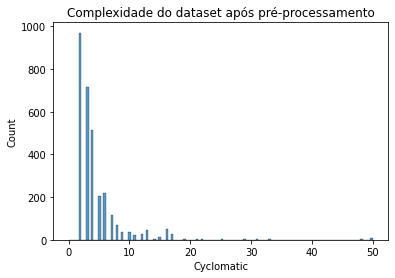

In [380]:
print_dataset_info()

<AxesSubplot:title={'center':'Contribuição de cada projeto no dataset'}, xlabel='count', ylabel='Project'>

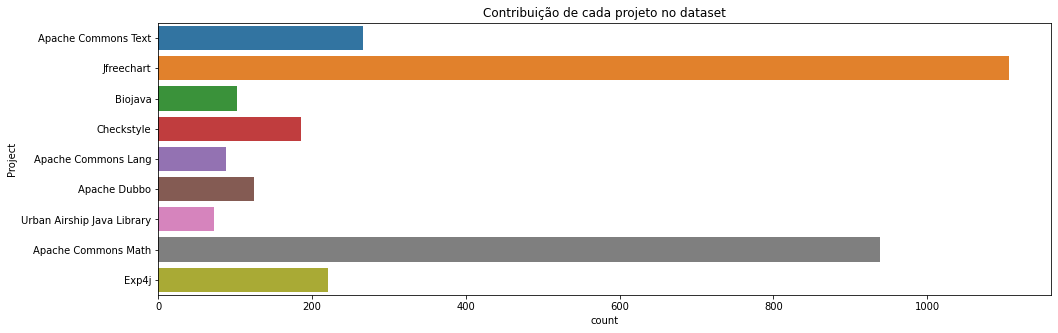

In [381]:
def signature_to_project(signature):
    project = ''
    
    if 'com.puppycrawl.tools.checkstyle' in signature:
        project = 'Checkstyle'
    elif 'exp4j' in signature:
        project = 'Exp4j'
    elif 'biojava' in signature:
        project = 'Biojava'
    elif 'org.jfree' in signature:
        project = 'Jfreechart'
    elif 'com.urbanairship' in signature:
        project = 'Urban Airship Java Library'
    elif 'org.apache.commons.text' in signature:
        project = 'Apache Commons Text'
    elif 'dubbo' in signature:
        project = 'Apache Dubbo'
    elif 'org.apache.commons.lang3' in signature:
        project = 'Apache Commons Lang'
    elif 'math3' in signature:
        project = 'Apache Commons Math'
        
    return project

d2 = dataset
d2['Project'] = dataset['Name'].apply(signature_to_project)
plt.figure(figsize=(16,5))
plt.title("Contribuição de cada projeto no dataset")

contrib_projetos = d2.groupby('Project')
contrib_projetos = contrib_projetos.count()

sns.countplot(y='Project', data=d2, orient='h')

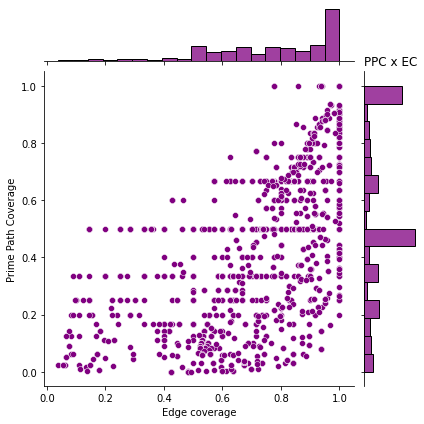

In [382]:
ax = sns.jointplot(x='EdgeCoverage', y='PrimePathCoverage', data=dataset, kind='scatter', color='purple')
ax.set_axis_labels('Edge coverage', 'Prime Path Coverage')
plt.title("PPC x EC")
plt.show(ax)

<AxesSubplot:title={'center':'Correlação das métricas'}>

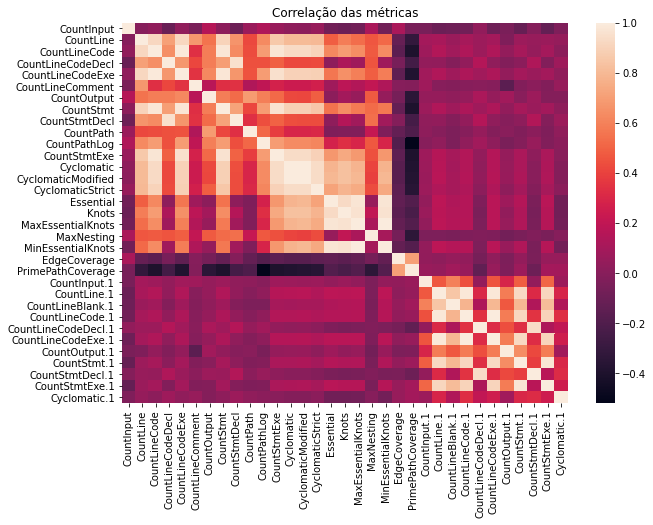

In [383]:
plt.figure(figsize=(10,7))
plt.title("Correlação das métricas")
sns.heatmap(dataset.corr())

In [384]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3105 entries, 1091 to 2424
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 3105 non-null   object 
 1   CountInput           3105 non-null   int64  
 2   CountLine            3105 non-null   int64  
 3   CountLineCode        3105 non-null   int64  
 4   CountLineCodeDecl    3105 non-null   int64  
 5   CountLineCodeExe     3105 non-null   int64  
 6   CountLineComment     3105 non-null   int64  
 7   CountOutput          3105 non-null   int64  
 8   CountStmt            3105 non-null   int64  
 9   CountStmtDecl        3105 non-null   int64  
 10  CountPath            3105 non-null   int64  
 11  CountPathLog         3105 non-null   int64  
 12  CountStmtExe         3105 non-null   int64  
 13  Cyclomatic           3105 non-null   int64  
 14  CyclomaticModified   3105 non-null   int64  
 15  CyclomaticStrict     3105 non-null 

In [385]:
dataset.describe()

,CountInput,CountLine,CountLineCode,CountLineCodeDecl,CountLineCodeExe,CountLineComment,CountOutput,CountStmt,CountStmtDecl,CountPath,...,CountLine.1,CountLineBlank.1,CountLineCode.1,CountLineCodeDecl.1,CountLineCodeExe.1,CountOutput.1,CountStmt.1,CountStmtDecl.1,CountStmtExe.1,Cyclomatic.1
count,3105.000000,3105.000000,3105.000000,3105.000000,3105.000000,3105.000000,3105.000000,3105.000000,3105.000000,3105.000000,...,3105.000000,3105.000000,3105.000000,3105.000000,3105.000000,3105.000000,3105.000000,3105.000000,3105.000000,3105.000000
mean,26.191948,29.236071,18.312399,3.397746,12.527536,9.910789,6.095330,12.806763,3.383897,79.771659,...,21.391304,2.235749,17.023833,4.571659,14.179066,7.681481,13.544605,4.272464,9.272142,1.455717
std,44.237780,24.326627,17.667287,4.038466,13.799885,9.304491,5.333823,12.068587,3.842434,675.244661,...,23.526057,4.929903,17.327726,3.295494,16.852380,5.132396,13.828991,3.116793,12.957318,1.272752
min,1.000000,4.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,3.000000,0.000000,3.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,1.000000
25%,6.000000,17.000000,9.000000,1.000000,5.000000,6.000000,3.000000,6.000000,2.000000,2.000000,...,10.000000,0.000000,8.000000,3.000000,6.000000,5.000000,6.000000,2.000000,3.000000,1.000000
50%,10.000000,22.000000,13.000000,2.000000,9.000000,7.000000,5.000000,9.000000,2.000000,4.000000,...,16.000000,1.000000,13.000000,4.000000,10.000000,7.000000,10.000000,3.000000,6.000000,1.000000
75%,22.000000,32.000000,20.000000,3.000000,13.000000,11.000000,8.000000,15.000000,3.000000,6.000000,...,25.000000,3.000000,20.000000,5.000000,17.000000,9.000000,16.000000,5.000000,11.000000,1.000000
max,201.000000,431.000000,225.000000,51.000000,194.000000,156.000000,58.000000,144.000000,49.000000,6912.000000,...,395.000000,97.000000,273.000000,27.000000,270.000000,59.000000,214.000000,25.000000,207.000000,20.000000


# Funções uteis

In [386]:
k = 10
metricas_erro = [
    'r2', 'max_error', 'neg_mean_absolute_error',
    'neg_mean_squared_error', 'neg_root_mean_squared_error',
    'neg_mean_squared_log_error', 'neg_median_absolute_error'
]
previsores = [
    # Método testado
    'CountInput','CountLine','CountLineCode','CountLineCodeDecl',
    'CountLineCodeExe','CountLineComment','CountOutput','CountStmt',
    'CountStmtDecl','CountPath','CountPathLog','CountStmtExe',
    'Cyclomatic','CyclomaticModified','CyclomaticStrict','Essential',
    'Knots','MaxEssentialKnots','MaxNesting','MinEssentialKnots','EdgeCoverage',
    
    # Método de teste
    'CountInput.1','CountLine.1','CountLineBlank.1',
    'CountLineCode.1','CountLineCodeDecl.1','CountLineCodeExe.1',
    'CountOutput.1','CountStmt.1', 'CountStmtDecl.1',
    'CountStmtExe.1','Cyclomatic.1'
]

In [387]:
def escalonador(dados):
    scaler = MinMaxScaler()
    #scaler = StandardScaler()
    return scaler.fit_transform(dados)

def evaluate(previsores, classificador, d = dataset, k=11, apenas_escalonamento=False):
    ppc = d['PrimePathCoverage'].values
    previsores_content = d[previsores].values

    if not apenas_escalonamento:
        resultados = cross_validate(
                classificador, 
                previsores_content, 
                ppc, 
                cv=k, 
                scoring=metricas_erro, 
                return_estimator=True
        )
        
        print('-----< SEM ESCALONAMENTO >-----')
        print('Mean Abs Error: ', abs(resultados['test_neg_mean_absolute_error'].mean()))
        print('Mean Sqr Error: ', abs(resultados['test_neg_mean_squared_error'].mean()))
        print('Mean Sqr Log Error: ', abs(resultados['test_neg_mean_squared_log_error'].mean()))
        print('Mean Median Error: ', abs(resultados['test_neg_median_absolute_error'].mean()))
        print('R2 Score: ', abs(resultados['test_r2'].mean()))
        
    resultados_escalonados = cross_validate(
            classificador, 
            escalonador(previsores_content), 
            ppc, 
            cv=k, 
            scoring=metricas_erro, 
            return_estimator=True
    )
    
    print('-----< COM ESCALONAMENTO >-----')
    print('Mean Abs Error: ', abs(resultados_escalonados['test_neg_mean_absolute_error'].mean()))
    print('Mean Sqr Error: ', abs(resultados_escalonados['test_neg_mean_squared_error'].mean()))
    print('Mean Sqr Log Error: ', abs(resultados_escalonados['test_neg_mean_squared_log_error'].mean()))
    print('Mean Median Error: ', abs(resultados_escalonados['test_neg_median_absolute_error'].mean()))
    print('R2 Score: ', abs(resultados_escalonados['test_r2'].mean()))

In [388]:
def feature_importance(classificador, d = dataset, prev = previsores):
    ppc = d['PrimePathCoverage'].values
    importance_dataset = pd.DataFrame(
            [0]*len(prev),
            index=prev,
            columns=['importance']
    )
    previsores_content = d[prev].values
    resultados = cross_validate(
            classificador, 
            previsores_content, 
            ppc, 
            cv=k, 
            scoring=metricas_erro,
            return_estimator=True
    )
    resultados_escalonados = cross_validate(
            classificador, 
            escalonador(previsores_content), 
            ppc, 
            cv=k, 
            scoring=metricas_erro,
            return_estimator=True
    )
    
    print('-----< SEM ESCALONAMENTO >-----')
    #print(resultados)
    for idx,estimator in enumerate(resultados['estimator']):
        feature_importances = pd.DataFrame(estimator.feature_importances_,
                                           index=prev,
                                           columns=['importance'])
        importance_dataset += feature_importances
 
    #print(importance_dataset) 
    importance_dataset['mean'] = importance_dataset['importance'] / k
    plt.figure(figsize=(10,9))
    plt.title("Feature importance - Random forest - K = 10 - Mean")
    plt.barh(prev, importance_dataset['mean'].values)
    plt.show()
    
    importance_dataset = pd.DataFrame(
            [0]*len(prev),
            index=prev,
            columns=['importance']
    )
    print('\n')
    
    print('-----< COM ESCALONAMENTO >-----')
    for idx,estimator in enumerate(resultados_escalonados['estimator']):
        feature_importances = pd.DataFrame(estimator.feature_importances_,
                                           index=prev,
                                           columns=['importance'])
        importance_dataset += feature_importances

    importance_dataset['mean'] = importance_dataset['importance'] / k
    #print(importance_dataset)
    plt.figure(figsize=(10,9))
    plt.title("Feature importance - Random forest - K = 10 - Mean")
    plt.barh(prev, importance_dataset['mean'].values)
    plt.show()

# Experimentos

## Linear Regression

### Com EC

In [389]:
for previsor in previsores:
    print('PREVISOR ', previsor)
    evaluate([
        previsor
    ], LinearRegression(fit_intercept=False), dataset)
    print('\n')

PREVISOR  CountInput
-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.5113811723121303
Mean Sqr Error:  0.3443939420612599
Mean Sqr Log Error:  0.16933608361345154
Mean Median Error:  0.4712196897190062
R2 Score:  4.868084925774024
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.5146063127227829
Mean Sqr Error:  0.3474823595691958
Mean Sqr Log Error:  0.17263893146338755
Mean Median Error:  0.474078699886199
R2 Score:  4.90730113161497


PREVISOR  CountLine
-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.4787151759703379
Mean Sqr Error:  0.4151159843941102
Mean Sqr Log Error:  0.14761571730346787
Mean Median Error:  0.4275589682082019
R2 Score:  5.273851622709836
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.508558050839172
Mean Sqr Error:  0.46148135401431695
Mean Sqr Log Error:  0.1656806629765257
Mean Median Error:  0.4524008959433639
R2 Score:  5.984368240953999


PREVISOR  CountLineCode
-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.5361465396780868
Mean Sqr Error

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.39901951867883695
Mean Sqr Error:  0.26391346556805145
Mean Sqr Log Error:  0.10836491248962475
Mean Median Error:  0.3643533693203723
R2 Score:  3.417083712556496
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.422558539114257
Mean Sqr Error:  0.2864299925582319
Mean Sqr Log Error:  0.1238792899540723
Mean Median Error:  0.3890979040502861
R2 Score:  3.8092225409191567


PREVISOR  CountLineBlank.1
-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.4900558501633002
Mean Sqr Error:  0.34189914555295303
Mean Sqr Log Error:  0.16799651558590345
Mean Median Error:  0.45652914144510603
R2 Score:  4.787292234575727
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.4900558501633002
Mean Sqr Error:  0.3418991455529529
Mean Sqr Log Error:  0.16799651558590345
Mean Median Error:  0.45652914144510603
R2 Score:  4.787292234575726


PREVISOR  CountLineCode.1
-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.38749383818524913
Mean Sqr Error:  0

In [390]:
evaluate([
    'EdgeCoverage'
], LinearRegression(fit_intercept=False), dataset)

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.18701163847417382
Mean Sqr Error:  0.04978423480931995
Mean Sqr Log Error:  0.022762171207405393
Mean Median Error:  0.18675131092771824
R2 Score:  0.2052283031015255
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.1856371278999595
Mean Sqr Error:  0.04894545894387141
Mean Sqr Log Error:  0.022469251347105174
Mean Median Error:  0.186554019611708
R2 Score:  0.2178326581766573


In [391]:
evaluate([
    'MaxNesting'
], LinearRegression(fit_intercept=False), dataset)

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.3856041093161331
Mean Sqr Error:  0.24551971260558794
Mean Sqr Log Error:  0.10449696246431558
Mean Median Error:  0.30584146730206546
R2 Score:  2.9632427467693314
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.3856041093161332
Mean Sqr Error:  0.24551971260558803
Mean Sqr Log Error:  0.1044969624643156
Mean Median Error:  0.3058414673020656
R2 Score:  2.9632427467693323


### Sem EC

## SVR

### Com EC

In [395]:
evaluate([
    'CountOutput',
    'EdgeCoverage',
    'Knots',
    'CountStmtDecl',
    'CountLineCodeDecl'
], SVR(epsilon=0.3), dataset, apenas_escalonamento=True)

-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.15557701421484435
Mean Sqr Error:  0.033340735178907295
Mean Sqr Log Error:  0.015158177396452411
Mean Median Error:  0.14916278211598355
R2 Score:  0.4671170680235315


In [396]:
evaluate([
    'Cyclomatic', 
    'CyclomaticModified', 
    'CyclomaticStrict', 
    'CountInput', 
    'CountOutput',
    'EdgeCoverage',
    'CountStmtExe.1'
], SVR(epsilon=0.3), dataset, apenas_escalonamento=True)

-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.15312250527793178
Mean Sqr Error:  0.03281699966200945
Mean Sqr Log Error:  0.014481518650789827
Mean Median Error:  0.14763166798241195
R2 Score:  0.47911984064973334


In [398]:
evaluate([
    'MaxNesting', 
    'CountPath', 
    'CountStmtExe', 
    'CountInput', 
    'CountOutput',
    'CountStmtExe.1'
], SVR(epsilon=0.3), dataset, apenas_escalonamento=True)

-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.22216451452737507
Mean Sqr Error:  0.06683938092215654
Mean Sqr Log Error:  0.029111327234470595
Mean Median Error:  0.20609353798182728
R2 Score:  0.06947130686218693


In [399]:
evaluate([
    'CountInput','CountLine','CountOutput','CountPath','CountStmt','CountStmtDecl','Knots',
    'MaxNesting','MinEssentialKnots',
    
    'CountInput.1','CountLine.1','CountLineCodeDecl.1','CountOutput.1','CountStmtDecl.1','CountStmtExe.1'
], SVR(epsilon=0.2), dataset, apenas_escalonamento=True)

-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.20235347856804428
Mean Sqr Error:  0.0597414543678255
Mean Sqr Log Error:  0.025561697631554737
Mean Median Error:  0.18428156190551342
R2 Score:  0.04336074968356554


In [400]:
evaluate([
    'Cyclomatic', 
    'CyclomaticModified',
    'CountOutput',
    'Essential',
    'CountLine',
    'EdgeCoverage'
], SVR(epsilon=0.4), dataset, apenas_escalonamento=True)

-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.18126947138189653
Mean Sqr Error:  0.04693163283907308
Mean Sqr Log Error:  0.019932368497859367
Mean Median Error:  0.16115635935416703
R2 Score:  0.2447810677691809


### Sem EC

## Neural network

### Com EC

In [345]:
evaluate([
    'Cyclomatic', 
    'CyclomaticModified',
    'CountOutput',
    'Essential',
    'CountLine',
    'EdgeCoverage'
], MLPRegressor(), dataset)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\skl

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

In [346]:
evaluate([
    'Cyclomatic', 
    'CyclomaticModified',
    'CountOutput',
    'Essential',
    'CountLine',
    'EdgeCoverage'
], MLPRegressor(
        hidden_layer_sizes=(122,), 
        activation='tanh', 
        learning_rate='invscaling', 
        alpha=0.1,
        random_state=0
), dataset)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< COM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

In [347]:
evaluate([
    'CountInput','CountLine','CountOutput','CountPath','CountStmt','CountStmtDecl','Knots',
    'MaxNesting','MinEssentialKnots',
    
    'CountInput.1','CountLine.1','CountLineCodeDecl.1','CountOutput.1','CountStmtDecl.1','CountStmtExe.1'
], MLPRegressor(), dataset)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< COM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

In [348]:
evaluate([
    'MaxNesting', 
    'CountPath', 
    'CountStmtExe', 
    'CountInput', 
    'CountOutput',
    'CountStmtExe.1'
], MLPRegressor(activation='tanh'), dataset)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< COM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

In [349]:
evaluate([
    'Cyclomatic', 
    'CyclomaticModified', 
    'CyclomaticStrict', 
    'CountInput', 
    'CountOutput',
    'EdgeCoverage',
    'CountStmtExe.1'
], MLPRegressor(activation='tanh'), dataset)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< COM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

### Sem EC

## Random forest

### Com EC

-----< SEM ESCALONAMENTO >-----


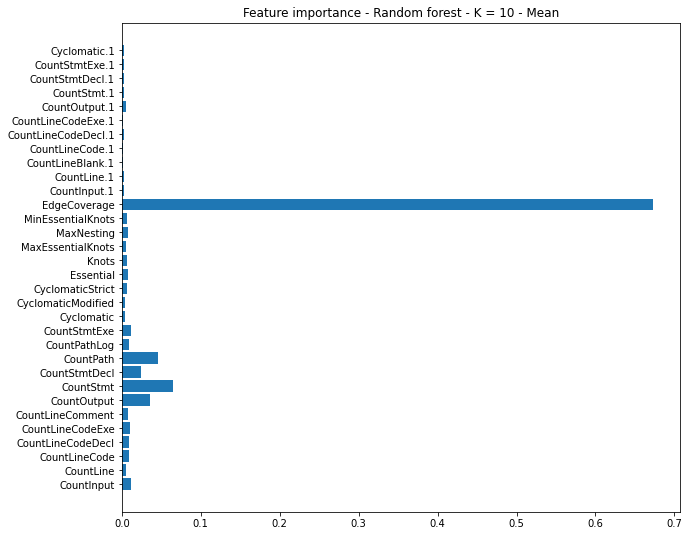



-----< COM ESCALONAMENTO >-----


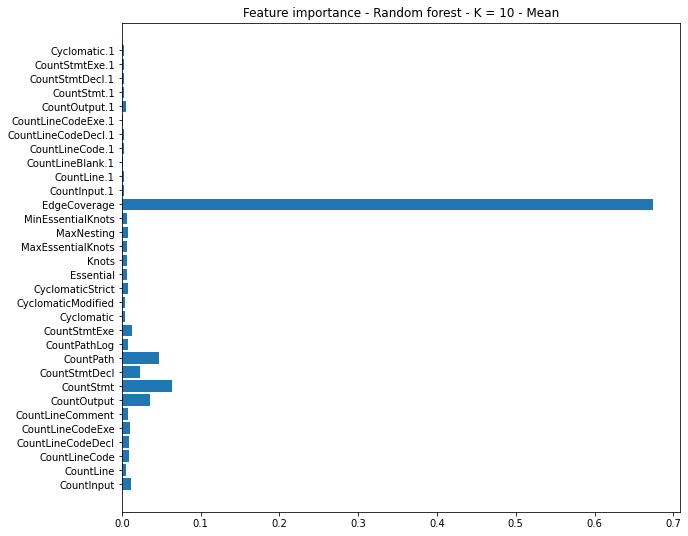

In [401]:
feature_importance(RandomForestRegressor())

In [402]:
evaluate([
    'CountOutput',
    'EdgeCoverage',
    'CountPath',
    'CountStmt'
], RandomForestRegressor(), dataset)

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.09167264960291784
Mean Sqr Error:  0.021684988667657227
Mean Sqr Log Error:  0.009536436803967123
Mean Median Error:  0.05850024503438675
R2 Score:  0.6588496581314233
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.09132578970042254
Mean Sqr Error:  0.02211723569989765
Mean Sqr Log Error:  0.009722834433154833
Mean Median Error:  0.053583703679653656
R2 Score:  0.6520775935271446


In [403]:
evaluate([
    'CountOutput',
    'EdgeCoverage',
    'Knots',
    'CountStmtDecl',
    'CountLineCodeDecl'
], RandomForestRegressor(), dataset)

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.0995837606507999
Mean Sqr Error:  0.025300881537751604
Mean Sqr Log Error:  0.011677169217407905
Mean Median Error:  0.05342043255065425
R2 Score:  0.5994499878039382
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.09877311895697556
Mean Sqr Error:  0.02537202155804597
Mean Sqr Log Error:  0.01175981702828857
Mean Median Error:  0.05240257503426562
R2 Score:  0.5987042512155019


In [404]:
evaluate([
    'CountOutput',
    'CountPath',
    'CountStmt'
], RandomForestRegressor(), dataset)

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.22781088816648143
Mean Sqr Error:  0.07703518346840695
Mean Sqr Log Error:  0.032580453785000976
Mean Median Error:  0.2184625626390084
R2 Score:  0.257477805905481
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.22865024204537143
Mean Sqr Error:  0.07787146287846852
Mean Sqr Log Error:  0.0330047873804056
Mean Median Error:  0.21343606976123122
R2 Score:  0.2667670088288965


In [405]:
evaluate([
    'CountOutput',
    'Knots',
    'CountStmtDecl',
    'CountLineCodeDecl'
], RandomForestRegressor(), dataset)

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.2500134780534385
Mean Sqr Error:  0.09667711390479633
Mean Sqr Log Error:  0.040875664488997876
Mean Median Error:  0.2329442643725378
R2 Score:  0.5614366681881309
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.2518931553522203
Mean Sqr Error:  0.0981362303442261
Mean Sqr Log Error:  0.041461232777620746
Mean Median Error:  0.22900045096051877
R2 Score:  0.588814223340009


### Sem EC

-----< SEM ESCALONAMENTO >-----


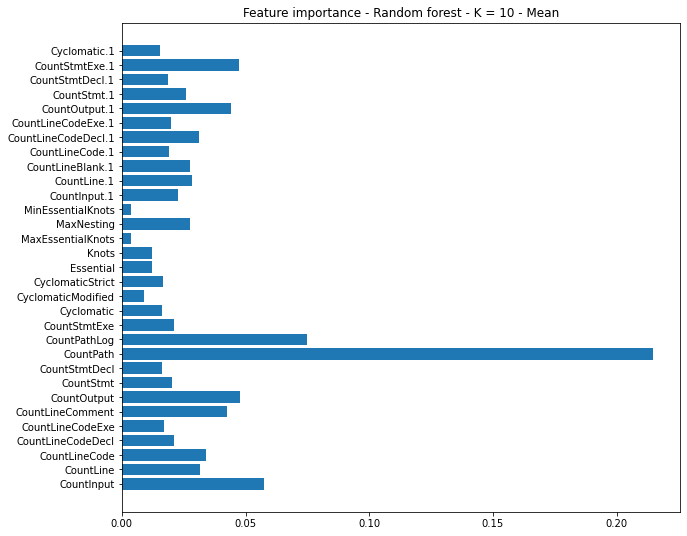



-----< COM ESCALONAMENTO >-----


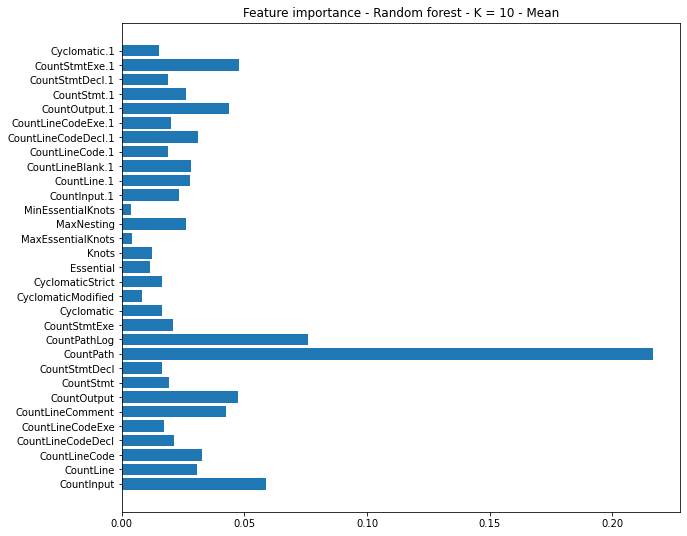

In [406]:
feature_importance(RandomForestRegressor(), prev=[
    # Método testado
    'CountInput','CountLine','CountLineCode','CountLineCodeDecl',
    'CountLineCodeExe','CountLineComment','CountOutput','CountStmt',
    'CountStmtDecl','CountPath','CountPathLog','CountStmtExe',
    'Cyclomatic','CyclomaticModified','CyclomaticStrict','Essential',
    'Knots','MaxEssentialKnots','MaxNesting','MinEssentialKnots',
    
    # Método de teste
    'CountInput.1','CountLine.1','CountLineBlank.1',
    'CountLineCode.1','CountLineCodeDecl.1','CountLineCodeExe.1',
    'CountOutput.1','CountStmt.1', 'CountStmtDecl.1',
    'CountStmtExe.1','Cyclomatic.1'
])

In [407]:
evaluate([
    'CountStmtExe.1',
    'MaxNesting',
    'CountPath',
    'CountOutput.1',
    'CountLineCodeExe.1'
], RandomForestRegressor(), dataset)

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.20828936188333588
Mean Sqr Error:  0.06647778439320297
Mean Sqr Log Error:  0.027690746020513145
Mean Median Error:  0.18453051187688574
R2 Score:  0.08084449229774072
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.20833346044975232
Mean Sqr Error:  0.06666811287859736
Mean Sqr Log Error:  0.027762008265652297
Mean Median Error:  0.18483038023252
R2 Score:  0.0824481593839596


In [408]:
evaluate([
    # Método testado
    'CountInput','CountLine','CountLineCode','CountLineCodeDecl',
    'CountLineCodeExe','CountLineComment','CountOutput','CountStmt',
    'CountStmtDecl','CountPath','CountPathLog','CountStmtExe',
    'Cyclomatic','CyclomaticModified','CyclomaticStrict','Essential',
    'Knots','MaxEssentialKnots','MaxNesting','MinEssentialKnots',
    
    # Método de teste
    'CountInput.1','CountLine.1','CountLineBlank.1',
    'CountLineCode.1','CountLineCodeDecl.1','CountLineCodeExe.1',
    'CountOutput.1','CountStmt.1', 'CountStmtDecl.1',
    'CountStmtExe.1','Cyclomatic.1'
], RandomForestRegressor(), dataset)

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.1988715766437448
Mean Sqr Error:  0.05635454956707808
Mean Sqr Log Error:  0.023712936813696028
Mean Median Error:  0.18719852020202013
R2 Score:  0.09454234226670848
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.20101808197579435
Mean Sqr Error:  0.05722642185850848
Mean Sqr Log Error:  0.02407890507535598
Mean Median Error:  0.1917282050865801
R2 Score:  0.07984004724733795


In [409]:
evaluate([
    'CountStmtExe.1',
    'MaxNesting',
    'CountPath',
    'CountOutput.1',
    'CountLineCodeExe.1',
    'Cyclomatic',
    'CountInput',
    'CountOutput',
], RandomForestRegressor(), dataset)

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.20063516114360072
Mean Sqr Error:  0.0606765635943872
Mean Sqr Log Error:  0.0252402778494368
Mean Median Error:  0.17626946955922865
R2 Score:  0.018614489518947064
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.20054670989320114
Mean Sqr Error:  0.0605049742749018
Mean Sqr Log Error:  0.025195293033805435
Mean Median Error:  0.1761365586580087
R2 Score:  0.020415433742453158
